In [ ]:
#  5 grocery store data -> num_likes, num_pos, num_negs

In [5]:
import pandas as pd
import numpy as np
from numpy import random
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from nltk.corpus import stopwords
import gensim

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from scipy import stats
from sklearn.pipeline import Pipeline

import sys
sys.path.insert(0, './readability/')
sys.path.insert(0, './cleaning/')

from readability import Readability 
from text_cleaner import replace_with_regex

sns.set_style("darkgrid")

%matplotlib inline

/Users/seoyeonchang/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/seoyeonchang/anaconda/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


### Num_likes

In [74]:
# read csv 
wholefoods = pd.read_csv('./datasets/WholeFoods_facebook_statuses.csv')
sprouts = pd.read_csv('./datasets/SproutsFarmersMarket_facebook_statuses.csv')
walmart = pd.read_csv('./datasets/walmart_facebook_statuses.csv')
safeway = pd.read_csv('./datasets/Safeway_facebook_statuses.csv')
kroger = pd.read_csv('./datasets/Kroger_facebook_statuses.csv')

# create dataframe list
df_list = [wholefoods, sprouts, walmart, safeway, kroger]

# set the name of column of emotions I'll analyze
emotion_type = "num_likes"

# filter extreme outliers (after looking up distribution of the data)
from scipy import stats

def filter_outliers(df, percentage):
    threshold = stats.scoreatpercentile(df[emotion_type], per=percentage)
    df = df[df[emotion_type] <= threshold]
    return df

for i, df in enumerate(df_list):
    new_df = filter_outliers(df, 98)
    df_list[i] = new_df

# fill_na_and_reset_index 
def fill_na_and_reset_index(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)
    # reset index
    df.index = range(df.shape[0])
    return df

for i, df in enumerate(df_list):
    new_df = fill_na_and_reset_index(df)
    df_list[i] = new_df

# filter out posts with a very small number of likes(cut off: least 2%)

def filter_low_scores(df, percentage):
    least_ten = stats.scoreatpercentile(df.num_likes, per=percentage)
    df = df[df.num_likes >= least_ten]
    return df

for i, df in enumerate(df_list):
    new_df = filter_low_scores(df, 2)
    df_list[i] = new_df
    
# fill_na_and_reset_index again
for i, df in enumerate(df_list):
    new_df = fill_na_and_reset_index(df)
    df_list[i] = new_df

# normalize the data dividing num_likes by the number of fans who like the each page(May 26, 2017)
num_like_page_wholefoods = 4182807.0
num_like_page_sprouts = 1382503.0
num_like_page_walmart = 33200531.0
num_like_page_safeway = 1300844.0
num_like_page_kroger = 1393202.0

df_list[0][emotion_type] = df_list[0][emotion_type].map(lambda x: x / num_like_page_wholefoods)
df_list[1][emotion_type] = df_list[1][emotion_type].map(lambda x: x / num_like_page_sprouts)
df_list[2][emotion_type] = df_list[2][emotion_type].map(lambda x: x / num_like_page_walmart)
df_list[3][emotion_type] = df_list[3][emotion_type].map(lambda x: x / num_like_page_safeway)
df_list[4][emotion_type] = df_list[4][emotion_type].map(lambda x: x / num_like_page_kroger)
    

def df_combine_clean(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)

    # reset index
    df.index = range(df.shape[0])

    # fill na with empty string
    df["status_message"] = df["status_message"].fillna("")
    df["link_name"] = df["link_name"].fillna("")

    # combine 'status messsage' and 'link name' column into 'text column' 
    df["text"] = df["status_message"].map(str) + " " + df["link_name"]

    # clean text column with 'replace_with_regex' function
    # remove numbers, special characters
    df['text'] = df['text'].map(lambda x: replace_with_regex(x))

    return df

for i, df in enumerate(df_list):
    new_df = df_combine_clean(df)
    df_list[i] = new_df

# reformulate df with columns relavant for modeling
def reformulate_df(df):
    df = df[['status_type', emotion_type, 'text', 'status_message', 'link_name', 'status_published']]
    return df

for i, df in enumerate(df_list):
    new_df = reformulate_df(df)
    df_list[i] = new_df
    
# combine 5 dataframes into one
df = pd.concat(df_list, axis =0)

#include more stopwords after looking into the text data for each dataset
stop = stopwords.words('english')
new_stop = ["timeline", "photos", "th", "wholefoodsmarket", "com", "http", "archive", "weve", "www",
           'whole', "market", "do", "you", "blog", "here", "timeline photos", "throughout", "us", 
            "know", "would", "users", "nan", "cover", "https", "facebook", "instagram", "user",
           "aack", "sprouts", "farmers", "market", "com", "brand", "phoenix", "az", "grand", "express", 
            "enter", "win", "timeline", "location", "express", "high", "street", "access", "complete", 
            "winning", "item", "right", "facebook", "photos", "great",  "get", "abc", "sharing", "activity", 
            "year", "acts", "actual", "actually", "yet", "walmart", "better", "black", "www", "first", "everything",
            "store", "back", "tell", "us", "timeline", "cover", "photo", "use", "vary", "pinterest", "able",
           "time" , "tab", "savings", "board", "next", "online", "time", "restrictions", "apply", "like", "timeline", 
            "photos", "kroger", "com", "must", "redeem", "pm", "pt", "redeem", "join", "us", "chance", "win", "tell", 
            "us", "breast", "cancer", "new", "year", "show", "us", "coca", "cola", "january", "th", "oh", "june", 
            "first", "customers", "receive","oz pm pt"]

stop.extend(new_stop)

def create_target(df):
    # mean of num_loves col
    mean = df[emotion_type].mean()
    # create a target column for classification dividing num_loves into 2 classes
    df['target'] = df[emotion_type].map(lambda x: 1 if x > mean else 0)
    return df

df = create_target(df)
    
# fill_na_and_reset_index again
df = fill_na_and_reset_index(df)
    
# I won't use ngram_range for classification because ngrams increases the number of columns 
# more text columns, less accurate prediction

# Tfidf Vectorizer in order to make text sparse matrix
tvt =  TfidfVectorizer(strip_accents='unicode', stop_words = stop, min_df=2)
X_all=  tvt.fit_transform(df["text"])
x_df =  pd.DataFrame(X_all.toarray(), columns=tvt.get_feature_names())

# feature engineering -> create new columns for length of text

# create new columns for length of 2 text columns(status message & link name)
df['len_status_message'] = df['status_message'].map(lambda x: len(x))
df['len_link_name'] = df['link_name'].map(lambda x: len(x))

len_text = df[['len_status_message', 'len_link_name']]

#combine x_df + len_text to create predictor df
df_len_text = pd.concat([x_df, len_text], axis=1)

# fill_na_and_reset_index again
final_df = fill_na_and_reset_index(df_len_text)

final_df = x_df

final_df['target'] = df.target

df_0 = final_df[final_df.target == 0] 
df_1 = final_df[final_df.target == 1]

assert(df.shape[0] == df_0.shape[0] + df_1.shape[0])

df_1_oversample = df_1.sample(n=df_0.shape[0], replace=True)
# df_0_subsample = df_0.sample(n=df_1.shape[0], replace=True)
df_balanced = df_0.append(df_1_oversample)

# predictors and target
X = df_balanced
y = df_balanced['target']

# train test split
del(X['target'])
X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y, train_size=0.7, random_state=8)

# AdaBoostClassifier using DeicisionClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
dc = DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=50, max_depth=50, random_state=11, max_features=.8, class_weight="balanced")
estimator = AdaBoostClassifier(base_estimator=dc, n_estimators=40, learning_rate=.001)
estimator.fit(X_train, y_train)
print "AdaBoostClassifier Score: ", estimator.score(X_test, y_test) #0.9125

In [7]:
#classification report
from sklearn.metrics import classification_report, confusion_matrix

predicted = estimator.predict(X_test)
clfr = classification_report(y_test, predicted)

print clfr

             precision    recall  f1-score   support

          0       0.93      0.79      0.86      3722
          1       0.82      0.94      0.88      3813

avg / total       0.88      0.87      0.87      7535



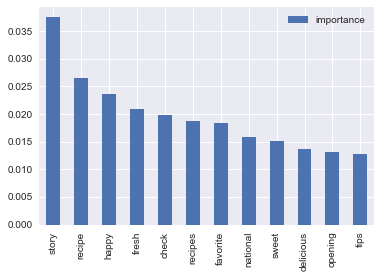

In [10]:
importances = estimator.feature_importances_
feature_importance = pd.DataFrame(data=importances, index=X.columns, columns=["importance"])
feature_importance.sort_values('importance', ascending=False)[0:12].plot(kind='bar')

In [41]:
# create new columns for length of 2 text columns(status message & link name)
df['len_status_message'] = df['status_message'].map(lambda x: len(x))
df['len_link_name'] = df['link_name'].map(lambda x: len(x))


In [42]:
df.columns

Index([u'status_type', u'num_likes', u'text', u'status_message', u'link_name',
       u'target', u'len_status_message', u'len_link_name'],
      dtype='object')

In [43]:
mean = df['num_likes'].mean()
df['target'] = df['num_likes'].map(lambda x: 1 if x > mean else 0)

In [18]:
df_1 = df[df['target'] == 1]
df_0 = df[df['target'] == 0]

In [22]:
df_1.shape

(2304, 10)

In [23]:
df_0.shape

(12558, 10)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14862 entries, 0 to 14861
Data columns (total 10 columns):
status_type           14862 non-null object
num_likes             14862 non-null float64
text                  14862 non-null object
status_message        14862 non-null object
link_name             14862 non-null object
target                14862 non-null int64
len_status_message    14862 non-null int64
len_link_name         14862 non-null int64
len_status_message    14862 non-null int64
len_link_name         14862 non-null int64
dtypes: float64(1), int64(5), object(4)
memory usage: 1.2+ MB


target
0    20.489409
1    15.342014
Name: len_link_name, dtype: float64


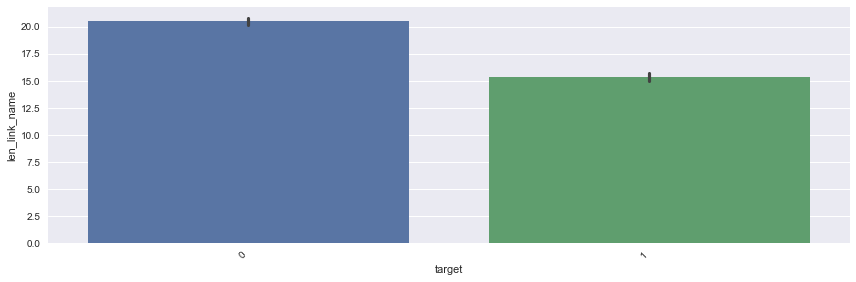

In [46]:
print(df.groupby('target')['len_link_name'].mean())
sns.factorplot(x='target', y='len_link_name',
               data=df, kind='bar', aspect=3).set_xticklabels(rotation=45, horizontalalignment='right')

target
0    164.840819
1    157.501302
Name: len_status_message, dtype: float64


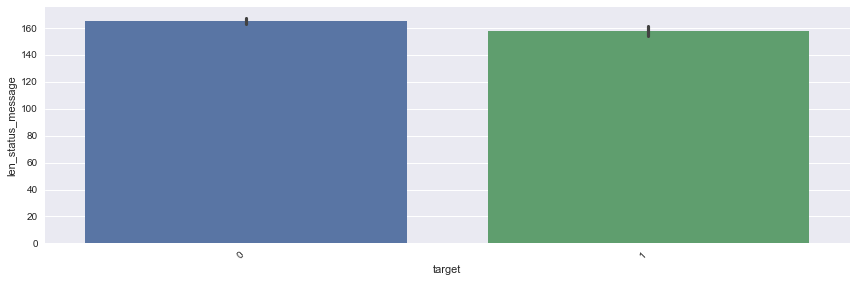

In [47]:
print(df.groupby('target')['len_status_message'].mean())
sns.factorplot(x='target', y='len_status_message',
               data=df, kind='bar', aspect=3).set_xticklabels(rotation=45, horizontalalignment='right')

In [95]:
df_0.text.iloc[45]

'Try this vegetarian Matzoh Ball Soup during Passover that uses garlic pure\xc3\xa9 in place of schmaltz. Roasted Garlic Matzoh Ball Soup'

In [50]:
df_0.text

0        Easy prep, endless possibilities! Stock up on ...
1        TeamCauliflower or TeamKale? Cauliflower Is th...
2        Meet the newest products you can't live withou...
3        It's just like tuna salad, only it's vegan! Ge...
4        Say hello to May! 🌼  Fresh Spring Party Ideas...
5        It's mealprep time! Make this tonight, enjoy a...
6         ways to use this limited-edition Tequila Lime...
7        Rise and shine! Power up with this Blueberry M...
9        Stock up on this week's DelishDeals through /....
10       Calling all cheese lovers! Try it: The Creamie...
11       If you're in Northern California... Swing by f...
12       Mornings are a little sweeter with an Apple Pi...
13                            Time to stock up! Hello Glow
14       Prep snap peas in a snap with this super quick...
15       If you're in the Austin area, let us know what...
16       Our fave new products this week include Simple...
17       Get a behind-the-scenes look from A Taste of K..

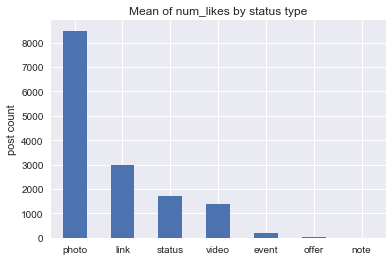

In [58]:
ax = df.status_type.value_counts().plot(kind="bar", rot=0)
ax.set_title("Mean of num_likes by status type")
ax.set_ylabel("post count")

In [72]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
#include more stopwords after looking into the text data for each dataset
stop = stopwords.words('english')
new_stop = ["timeline", "photos", "th", "wholefoodsmarket", "com", "http", "archive", "weve", "www",
           'whole', "market", "do", "you", "blog", "here", "timeline photos", "throughout", "us", 
            "know", "would", "users", "nan", "cover", "https", "facebook", "instagram", "user",
           "aack", "sprouts", "farmers", "market", "com", "brand", "phoenix", "az", "grand", "express", 
            "enter", "win", "timeline", "location", "express", "high", "street", "access", "complete", 
            "winning", "item", "right", "facebook", "photos", "great",  "get", "abc", "sharing", "activity", 
            "year", "acts", "actual", "actually", "yet", "walmart", "better", "black", "www", "first", "everything",
            "store", "back", "tell", "us", "timeline", "cover", "photo", "use", "vary", "pinterest", "able",
           "time" , "tab", "savings", "board", "next", "online", "time", "restrictions", "apply", "like", "timeline", 
            "photos", "kroger", "com", "must", "redeem", "pm", "pt", "redeem", "join", "us", "chance", "win", "tell", 
            "us", "breast", "cancer", "new", "year", "show", "us", "coca", "cola", "january", "th", "oh", "june", 
            "first", "customers", "receive","oz pm pt", "gift card", "gift cards", 'gift', 'card', 'cards', 'co',
           'associates']

stop.extend(new_stop)


# Can't see any difference from histogram without stopwords
# I need to look into the n-grams(most frequent + least frequent) and decide to include more stopwords
cvt      =  CountVectorizer(strip_accents='unicode', stop_words=stop, ngram_range=(2,4))
X_all    =  cvt.fit_transform(df_1['text'])
# hist_counts(X_all)

## Positive vs negative Reactions

### Positive reactions

In [ ]:
# read csv 
wholefoods = pd.read_csv('./datasets/WholeFoods_facebook_statuses.csv')
sprouts = pd.read_csv('./datasets/SproutsFarmersMarket_facebook_statuses.csv')
walmart = pd.read_csv('./datasets/walmart_facebook_statuses.csv')
safeway = pd.read_csv('./datasets/Safeway_facebook_statuses.csv')
kroger = pd.read_csv('./datasets/Kroger_facebook_statuses.csv')

# create dataframe list
df_list = [wholefoods, sprouts, walmart, safeway, kroger]

# create a new columns called num_of_pos which sums up the total number of positive reactions 
def create_num_pos_col(df):
    df['num_pos'] = df['num_loves'] + df['num_hahas'] + df['num_wows']
    return df

for i, df in enumerate(df_list):
    new_df = create_num_pos_col(df)
    df_list[i] = new_df

# set the name of column of emotions I'll analyze
emotion_type = "num_pos"

# cut out rows before Mar 2016 when Facebook included various sub emojies 
# such as loves, wows, hahas, sads, angrys
# in order to analyze the relationship between those emojis and texts
import datetime as dt

def filter_out_before_march_2016(df):
    # transform 'status_published' column into datetime object
    df['status_published'] = pd.to_datetime(df['status_published'])
    # create new columns for year and month 
    df['year'] = df['status_published'].dt.year
    df['month'] = df['status_published'].dt.month
    # filter out rows before March 2016
    df = df[df['year'] > 2016]
    df = df[df['month'] >= 3]
    return df

for i, df in enumerate(df_list):
    new_df = filter_out_before_march_2016(df)
    df_list[i] = new_df

def fill_na_and_reset_index(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)
    # reset index
    df.index = range(df.shape[0])
    return df

for i, df in enumerate(df_list):
    new_df = fill_na_and_reset_index(df)
    df_list[i] = new_df

# filter extreme outliers (after looking up distribution of the data)
from scipy import stats

def filter_outliers(df, percentage):
    threshold = stats.scoreatpercentile(df[emotion_type], per=percentage)
    df = df[df[emotion_type] <= threshold]
    return df

for i, df in enumerate(df_list):
    new_df = filter_outliers(df, 98)
    df_list[i] = new_df

# fill_na_and_reset_index again
for i, df in enumerate(df_list):
    new_df = fill_na_and_reset_index(df)
    df_list[i] = new_df

# filter out posts with a very small number of likes(cut off: least 2%)

def filter_low_scores(df, percentage):
    least_ten = stats.scoreatpercentile(df.num_likes, per=percentage)
    df = df[df.num_likes >= least_ten]
    return df

for i, df in enumerate(df_list):
    new_df = filter_low_scores(df, 2)
    df_list[i] = new_df
    
# fill_na_and_reset_index again
for i, df in enumerate(df_list):
    new_df = fill_na_and_reset_index(df)
    df_list[i] = new_df

# normalize the data dividing num_likes by the number of fans who like the each page(May 26, 2017)
num_like_page_wholefoods = 4182807.0
num_like_page_sprouts = 1382503.0
num_like_page_walmart = 33200531.0
num_like_page_safeway = 1300844.0
num_like_page_kroger = 1393202.0

df_list[0][emotion_type] = df_list[0][emotion_type].map(lambda x: x / num_like_page_wholefoods)
df_list[1][emotion_type] = df_list[1][emotion_type].map(lambda x: x / num_like_page_sprouts)
df_list[2][emotion_type] = df_list[2][emotion_type].map(lambda x: x / num_like_page_walmart)
df_list[3][emotion_type] = df_list[3][emotion_type].map(lambda x: x / num_like_page_safeway)
df_list[4][emotion_type] = df_list[4][emotion_type].map(lambda x: x / num_like_page_kroger)
    

def df_combine_clean(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)

    # reset index
    df.index = range(df.shape[0])

    # fill na with empty string
    df["status_message"] = df["status_message"].fillna("")
    df["link_name"] = df["link_name"].fillna("")

    # combine 'status messsage' and 'link name' column into 'text column' 
    df["text"] = df["status_message"].map(str) + " " + df["link_name"]

    # clean text column with 'replace_with_regex' function
    # remove numbers, special characters
    df['text'] = df['text'].map(lambda x: replace_with_regex(x))

    return df

for i, df in enumerate(df_list):
    new_df = df_combine_clean(df)
    df_list[i] = new_df

# reformulate df with columns relavant for modeling
def reformulate_df(df):
    df = df[['status_type', emotion_type, 'text', 'status_message', 'link_name']]
    return df

for i, df in enumerate(df_list):
    new_df = reformulate_df(df)
    df_list[i] = new_df
    
# combine 5 dataframes into one
df = pd.concat(df_list, axis =0)

#include more stopwords after looking into the text data for each dataset
stop = stopwords.words('english')
new_stop = ["timeline", "photos", "th", "wholefoodsmarket", "com", "http", "archive", "weve", "www",
           'whole', "market", "do", "you", "blog", "here", "timeline photos", "throughout", "us", 
            "know", "would", "users", "nan", "cover", "https", "facebook", "instagram", "user",
           "aack", "sprouts", "farmers", "market", "com", "brand", "phoenix", "az", "grand", "express", 
            "enter", "win", "timeline", "location", "express", "high", "street", "access", "complete", 
            "winning", "item", "right", "facebook", "photos", "great",  "get", "abc", "sharing", "activity", 
            "year", "acts", "actual", "actually", "yet", "walmart", "better", "black", "www", "first", "everything",
            "store", "back", "tell", "us", "timeline", "cover", "photo", "use", "vary", "pinterest", "able",
           "time" , "tab", "savings", "board", "next", "online", "time", "restrictions", "apply", "like", "timeline", 
            "photos", "kroger", "com", "must", "redeem", "pm", "pt", "redeem", "join", "us", "chance", "win", "tell", 
            "us", "breast", "cancer", "new", "year", "show", "us", "coca", "cola", "january", "th", "oh", "june", 
            "first", "customers", "receive","oz pm pt"]

stop.extend(new_stop)



def create_target(df):
    # mean of num_loves col
    mean = df[emotion_type].mean()
    # create a target column for classification dividing num_loves into 2 classes
    df['target'] = df[emotion_type].map(lambda x: 1 if x > mean else 0)
    return df

df = create_target(df)
    
# fill_na_and_reset_index again
df = fill_na_and_reset_index(df)
    
# I won't use ngram_range for classification because ngrams increases the number of columns 
# more text columns, less accurate prediction

# Tfidf Vectorizer in order to make text sparse matrix
tvt =  TfidfVectorizer(strip_accents='unicode', stop_words = stop, min_df=2)
X_all=  tvt.fit_transform(df["text"])
x_df =  pd.DataFrame(X_all.toarray(), columns=tvt.get_feature_names())

# feature engineering -> create new columns for length of text

# create new columns for length of 2 text columns(status message & link name)
df['len_status_message'] = df['status_message'].map(lambda x: len(x))
df['len_link_name'] = df['link_name'].map(lambda x: len(x))

len_text = df[['len_status_message', 'len_link_name']]

#combine x_df + len_text to create predictor df
df_len_text = pd.concat([x_df, len_text], axis=1)

# fill_na_and_reset_index again
final_df = fill_na_and_reset_index(df_len_text)

final_df['target'] = df.target

df_0 = final_df[final_df.target == 0] 
df_1 = final_df[final_df.target == 1]

assert(df.shape[0] == df_0.shape[0] + df_1.shape[0])

df_1_oversample = df_1.sample(n=df_0.shape[0], replace=True)
# df_0_subsample = df_0.sample(n=df_1.shape[0], replace=True)
df_balanced = df_0.append(df_1_oversample)

# predictors and target
X = df_balanced
y = df_balanced['target']

# train test split
del(X['target'])
X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y, train_size=0.7, random_state=8)

# AdaBoostClassifier using DeicisionClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
dc = DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=50, max_depth=50, random_state=11, max_features=.8, class_weight="balanced")
estimator = AdaBoostClassifier(base_estimator=dc, n_estimators=40, learning_rate=.001)
estimator.fit(X_train, y_train)
print "AdaBoostClassifier Score: ", estimator.score(X_test, y_test) #0.9125

In [ ]:
#classification report
from sklearn.metrics import classification_report 

predicted = estimator.predict(X_test)
clfr = classification_report(y_test, predicted)

print clfr

In [ ]:
y_score = estimator.predict_proba(X_test)

# ROC 
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, color = 'blue', label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Num_likes Binary Classification ROC - Logistic Regression', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Negative reactions

In [ ]:
# read csv 
wholefoods = pd.read_csv('./datasets/WholeFoods_facebook_statuses.csv')
sprouts = pd.read_csv('./datasets/SproutsFarmersMarket_facebook_statuses.csv')
walmart = pd.read_csv('./datasets/walmart_facebook_statuses.csv')
safeway = pd.read_csv('./datasets/Safeway_facebook_statuses.csv')
kroger = pd.read_csv('./datasets/Kroger_facebook_statuses.csv')

# create dataframe list
df_list = [wholefoods, sprouts, walmart, safeway, kroger]

# create a new columns called num_of_pos which sums up the total number of positive reactions 
def create_num_negs_col(df):
    df['num_negs'] = df['num_sads'] + df['num_angrys'] 
    return df

for i, df in enumerate(df_list):
    new_df = create_num_negs_col(df)
    df_list[i] = new_df

# set the name of column of emotions I'll analyze
emotion_type = "num_negs"

# cut out rows before Mar 2016 when Facebook included various sub emojies 
# such as loves, wows, hahas, sads, angrys
# in order to analyze the relationship between those emojis and texts
import datetime as dt

def filter_out_before_march_2016(df):
    # transform 'status_published' column into datetime object
    df['status_published'] = pd.to_datetime(df['status_published'])
    # create new columns for year and month 
    df['year'] = df['status_published'].dt.year
    df['month'] = df['status_published'].dt.month
    # filter out rows before March 2016
    df = df[df['year'] > 2016]
    df = df[df['month'] >= 3]
    return df

for i, df in enumerate(df_list):
    new_df = filter_out_before_march_2016(df)
    df_list[i] = new_df

def fill_na_and_reset_index(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)
    # reset index
    df.index = range(df.shape[0])
    return df

for i, df in enumerate(df_list):
    new_df = fill_na_and_reset_index(df)
    df_list[i] = new_df

# filter extreme outliers (after looking up distribution of the data)
from scipy import stats

def filter_outliers(df, percentage):
    threshold = stats.scoreatpercentile(df[emotion_type], per=percentage)
    df = df[df[emotion_type] <= threshold]
    return df

for i, df in enumerate(df_list):
    new_df = filter_outliers(df, 98)
    df_list[i] = new_df

# fill_na_and_reset_index again
for i, df in enumerate(df_list):
    new_df = fill_na_and_reset_index(df)
    df_list[i] = new_df

# filter out posts with a very small number of likes(cut off: least 2%)

def filter_low_scores(df, percentage):
    least_ten = stats.scoreatpercentile(df.num_likes, per=percentage)
    df = df[df.num_likes >= least_ten]
    return df

for i, df in enumerate(df_list):
    new_df = filter_low_scores(df, 2)
    df_list[i] = new_df
    
# fill_na_and_reset_index again
for i, df in enumerate(df_list):
    new_df = fill_na_and_reset_index(df)
    df_list[i] = new_df

# normalize the data dividing num_likes by the number of fans who like the each page(May 26, 2017)
num_like_page_wholefoods = 4182807.0
num_like_page_sprouts = 1382503.0
num_like_page_walmart = 33200531.0
num_like_page_safeway = 1300844.0
num_like_page_kroger = 1393202.0

df_list[0][emotion_type] = df_list[0][emotion_type].map(lambda x: x / num_like_page_wholefoods)
df_list[1][emotion_type] = df_list[1][emotion_type].map(lambda x: x / num_like_page_sprouts)
df_list[2][emotion_type] = df_list[2][emotion_type].map(lambda x: x / num_like_page_walmart)
df_list[3][emotion_type] = df_list[3][emotion_type].map(lambda x: x / num_like_page_safeway)
df_list[4][emotion_type] = df_list[4][emotion_type].map(lambda x: x / num_like_page_kroger)
    

def df_combine_clean(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)

    # reset index
    df.index = range(df.shape[0])

    # fill na with empty string
    df["status_message"] = df["status_message"].fillna("")
    df["link_name"] = df["link_name"].fillna("")

    # combine 'status messsage' and 'link name' column into 'text column' 
    df["text"] = df["status_message"].map(str) + " " + df["link_name"]

    # clean text column with 'replace_with_regex' function
    # remove numbers, special characters
    df['text'] = df['text'].map(lambda x: replace_with_regex(x))

    return df

for i, df in enumerate(df_list):
    new_df = df_combine_clean(df)
    df_list[i] = new_df

# reformulate df with columns relavant for modeling
def reformulate_df(df):
    df = df[['status_type', emotion_type, 'text', 'status_message', 'link_name']]
    return df

for i, df in enumerate(df_list):
    new_df = reformulate_df(df)
    df_list[i] = new_df
    
# combine 5 dataframes into one
df = pd.concat(df_list, axis =0)

#include more stopwords after looking into the text data for each dataset
stop = stopwords.words('english')
new_stop = ["timeline", "photos", "th", "wholefoodsmarket", "com", "http", "archive", "weve", "www",
           'whole', "market", "do", "you", "blog", "here", "timeline photos", "throughout", "us", 
            "know", "would", "users", "nan", "cover", "https", "facebook", "instagram", "user",
           "aack", "sprouts", "farmers", "market", "com", "brand", "phoenix", "az", "grand", "express", 
            "enter", "win", "timeline", "location", "express", "high", "street", "access", "complete", 
            "winning", "item", "right", "facebook", "photos", "great",  "get", "abc", "sharing", "activity", 
            "year", "acts", "actual", "actually", "yet", "walmart", "better", "black", "www", "first", "everything",
            "store", "back", "tell", "us", "timeline", "cover", "photo", "use", "vary", "pinterest", "able",
           "time" , "tab", "savings", "board", "next", "online", "time", "restrictions", "apply", "like", "timeline", 
            "photos", "kroger", "com", "must", "redeem", "pm", "pt", "redeem", "join", "us", "chance", "win", "tell", 
            "us", "breast", "cancer", "new", "year", "show", "us", "coca", "cola", "january", "th", "oh", "june", 
            "first", "customers", "receive","oz pm pt"]

stop.extend(new_stop)

stop.extend(kroger_stopwords)
def create_target(df):
    # mean of num_loves col
    mean = df[emotion_type].mean()
    # create a target column for classification dividing num_loves into 2 classes
    df['target'] = df[emotion_type].map(lambda x: 1 if x > mean else 0)
    return df

df = create_target(df)
    
# fill_na_and_reset_index again
df = fill_na_and_reset_index(df)
    
# I won't use ngram_range for classification because ngrams increases the number of columns 
# more text columns, less accurate prediction

# Tfidf Vectorizer in order to make text sparse matrix
tvt =  TfidfVectorizer(strip_accents='unicode', stop_words = stop, min_df=2)
X_all=  tvt.fit_transform(df["text"])
x_df =  pd.DataFrame(X_all.toarray(), columns=tvt.get_feature_names())

# feature engineering -> create new columns for length of text

# create new columns for length of 2 text columns(status message & link name)
df['len_status_message'] = df['status_message'].map(lambda x: len(x))
df['len_link_name'] = df['link_name'].map(lambda x: len(x))

len_text = df[['len_status_message', 'len_link_name']]

#combine x_df + len_text to create predictor df
df_len_text = pd.concat([x_df, len_text], axis=1)

# fill_na_and_reset_index again
final_df = fill_na_and_reset_index(df_len_text)

final_df['target'] = df.target

df_0 = final_df[final_df.target == 0] 
df_1 = final_df[final_df.target == 1]

assert(df.shape[0] == df_0.shape[0] + df_1.shape[0])

df_1_oversample = df_1.sample(n=df_0.shape[0], replace=True)
# df_0_subsample = df_0.sample(n=df_1.shape[0], replace=True)
df_balanced = df_0.append(df_1_oversample)

# predictors and target
X = df_balanced
y = df_balanced['target']

# train test split
del(X['target'])
X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y, train_size=0.7, random_state=8)

# LogisticRegression
logreg = LogisticRegression(verbose=1)
logreg.fit(X_train, y_train)
print "logistic regression score: ", logreg.score(X_test, y_test)  # 0.9125

# AdaBoostClassifier using DeicisionClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
dc = DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=50, max_depth=50, random_state=11, max_features=.8, class_weight="balanced")
estimator = AdaBoostClassifier(base_estimator=dc, n_estimators=40, learning_rate=.001)
estimator.fit(X_train, y_train)
print "AdaBoostClassifier Score: ", estimator.score(X_test, y_test) #0.9125

In [ ]:
#classification report
from sklearn.metrics import classification_report 

predicted = estimator.predict(X_test)
clfr = classification_report(y_test, predicted)

print clfr

In [ ]:
y_score = estimator.predict_proba(X_test)

# ROC 
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, color = 'blue', label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Num_likes Binary Classification ROC - Logistic Regression', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [ ]:
from collections import Counter
Counter(y_test)

### Keyword Extraction

In [41]:
# num_likes & num_pos
# read csv 
wholefoods = pd.read_csv('./datasets/WholeFoods_facebook_statuses.csv')
sprouts = pd.read_csv('./datasets/SproutsFarmersMarket_facebook_statuses.csv')
walmart = pd.read_csv('./datasets/walmart_facebook_statuses.csv')
safeway = pd.read_csv('./datasets/Safeway_facebook_statuses.csv')
kroger = pd.read_csv('./datasets/Kroger_facebook_statuses.csv')

# create dataframe list
df_list = [wholefoods, sprouts, walmart, safeway, kroger]

# create a new columns called num_of_pos which sums up the total number of positive reactions 
def create_num_pos_col(df):
    df['num_likes_pos'] = df['num_likes'] + df['num_loves'] + df['num_hahas'] + df['num_wows']
    return df

for i, df in enumerate(df_list):
    new_df = create_num_pos_col(df)
    df_list[i] = new_df

# set the name of column of emotions I'll analyze
emotion_type = "num_likes_pos"

# cut out rows before Mar 2016 when Facebook included various sub emojies 
# such as loves, wows, hahas, sads, angrys
# in order to analyze the relationship between those emojis and texts

def fill_na_and_reset_index(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)
    # reset index
    df.index = range(df.shape[0])
    return df

for i, df in enumerate(df_list):
    new_df = fill_na_and_reset_index(df)
    df_list[i] = new_df

# filter extreme outliers (after looking up distribution of the data)
from scipy import stats

def filter_outliers(df, percentage):
    threshold = stats.scoreatpercentile(df[emotion_type], per=percentage)
    df = df[df[emotion_type] <= threshold]
    return df

for i, df in enumerate(df_list):
    new_df = filter_outliers(df, 98)
    df_list[i] = new_df

# fill_na_and_reset_index again
for i, df in enumerate(df_list):
    new_df = fill_na_and_reset_index(df)
    df_list[i] = new_df

# filter out posts with a very small number of likes(cut off: least 2%)

def filter_low_scores(df, percentage):
    least_ten = stats.scoreatpercentile(df.num_likes, per=percentage)
    df = df[df.num_likes >= least_ten]
    return df

for i, df in enumerate(df_list):
    new_df = filter_low_scores(df, 2)
    df_list[i] = new_df
    
# fill_na_and_reset_index again
for i, df in enumerate(df_list):
    new_df = fill_na_and_reset_index(df)
    df_list[i] = new_df

# normalize the data dividing num_likes by the number of fans who like the each page(May 26, 2017)
num_like_page_wholefoods = 4182807.0
num_like_page_sprouts = 1382503.0
num_like_page_walmart = 33200531.0
num_like_page_safeway = 1300844.0
num_like_page_kroger = 1393202.0

df_list[0][emotion_type] = df_list[0][emotion_type].map(lambda x: x / num_like_page_wholefoods)
df_list[1][emotion_type] = df_list[1][emotion_type].map(lambda x: x / num_like_page_sprouts)
df_list[2][emotion_type] = df_list[2][emotion_type].map(lambda x: x / num_like_page_walmart)
df_list[3][emotion_type] = df_list[3][emotion_type].map(lambda x: x / num_like_page_safeway)
df_list[4][emotion_type] = df_list[4][emotion_type].map(lambda x: x / num_like_page_kroger)
    

def df_combine_clean(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)

    # reset index
    df.index = range(df.shape[0])

    # fill na with empty string
    df["status_message"] = df["status_message"].fillna("")
    df["link_name"] = df["link_name"].fillna("")

    # combine 'status messsage' and 'link name' column into 'text column' 
    df["text"] = df["status_message"].map(str) + " " + df["link_name"]

    # clean text column with 'replace_with_regex' function
    # remove numbers, special characters
    df['text'] = df['text'].map(lambda x: replace_with_regex(x))

    return df

for i, df in enumerate(df_list):
    new_df = df_combine_clean(df)
    df_list[i] = new_df

# reformulate df with columns relavant for modeling
def reformulate_df(df):
    df = df[['status_type', emotion_type, 'text', 'status_message', 'link_name']]
    return df

for i, df in enumerate(df_list):
    new_df = reformulate_df(df)
    df_list[i] = new_df
    
# combine 5 dataframes into one
df = pd.concat(df_list, axis =0)

print "shape", df.shape

#include more stopwords after looking into the text data for each dataset
stop = stopwords.words('english')
new_stop = ["timeline", "photos", "th", "wholefoodsmarket", "com", "http", "archive", "weve", "www",
           'whole', "market", "do", "you", "blog", "here", "timeline photos", "throughout", "us", 
            "know", "would", "users", "nan", "cover", "https", "facebook", "instagram", "user",
           "aack", "sprouts", "farmers", "market", "com", "brand", "phoenix", "az", "grand", "express", 
            "enter", "win", "timeline", "location", "express", "high", "street", "access", "complete", 
            "winning", "item", "right", "facebook", "photos", "great",  "get", "abc", "sharing", "activity", 
            "year", "acts", "actual", "actually", "yet", "walmart", "better", "black", "www", "first", "everything",
            "store", "back", "tell", "us", "timeline", "cover", "photo", "use", "vary", "pinterest", "able",
           "time" , "tab", "savings", "board", "next", "online", "time", "restrictions", "apply", "like", "timeline", 
            "photos", "kroger", "com", "must", "redeem", "pm", "pt", "redeem", "join", "us", "chance", "win", "tell", 
            "us", "breast", "cancer", "new", "year", "show", "us", "coca", "cola", "january", "th", "oh", "june", 
            "first", "customers", "receive","oz pm pt"]

stop.extend(new_stop)

def create_target(df):
    # mean of num_loves col
    mean = df[emotion_type].mean()
    # create a target column for classification dividing num_loves into 2 classes
    df['target'] = df[emotion_type].map(lambda x: 1 if x > mean else 0)
    return df

df = create_target(df)
    
# fill_na_and_reset_index again
df = fill_na_and_reset_index(df)
    
# I won't use ngram_range for classification because ngrams increases the number of columns 
# more text columns, less accurate prediction

# Tfidf Vectorizer in order to make text sparse matrix
tvt =  TfidfVectorizer(strip_accents='unicode', stop_words = stop, min_df=2)
X_all=  tvt.fit_transform(df["text"])
x_df =  pd.DataFrame(X_all.toarray(), columns=tvt.get_feature_names())

# feature engineering -> create new columns for length of text

# create new columns for length of 2 text columns(status message & link name)
df['len_status_message'] = df['status_message'].map(lambda x: len(x))
df['len_link_name'] = df['link_name'].map(lambda x: len(x))

len_text = df[['len_status_message', 'len_link_name']]

#combine x_df + len_text to create predictor df
df_len_text = pd.concat([x_df, len_text], axis=1)

# fill_na_and_reset_index again
final_df = fill_na_and_reset_index(df_len_text)

final_df['target'] = df.target

df_0 = final_df[final_df.target == 0] 
df_1 = final_df[final_df.target == 1]

assert(df.shape[0] == df_0.shape[0] + df_1.shape[0])

df_1_oversample = df_1.sample(n=df_0.shape[0], replace=True)
# df_0_subsample = df_0.sample(n=df_1.shape[0], replace=True)
df_balanced = df_0.append(df_1_oversample)

# predictors and target
X = df_balanced
y = df_balanced['target']

print X.shape
print y.shape

# train test split
del(X['target'])
X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y, train_size=0.7, random_state=8)

# LogisticRegression
logreg = LogisticRegression(verbose=1)
logreg.fit(X_train, y_train)
print "logistic regression score: ", logreg.score(X_test, y_test)  # 0.9125

# AdaBoostClassifier using DeicisionClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
dc = DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=50, max_depth=50, random_state=11, max_features=.8, class_weight="balanced")
estimator = AdaBoostClassifier(base_estimator=dc, n_estimators=40, learning_rate=.001)
estimator.fit(X_train, y_train)
print "AdaBoostClassifier Score: ", estimator.score(X_test, y_test) #0.9125

shape (14862, 5)
(25152, 9578)
(25152,)
[LibLinear]logistic regression score:  0.810893188444
AdaBoostClassifier Score:  0.871587596077


In [2]:
#classification report
from sklearn.metrics import classification_report 

predicted = logreg.predict(X_test)
clfr = classification_report(y_test, predicted)

print clfr